# Optimizing the RNN

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading TensorBoard
%load_ext tensorboard

# Clear any logs from previous runs
# %rm -rf ./logs/

In [3]:
from tensorboard.plugins.hparams import api as hp

In [4]:
import random
random.seed(123)

# Configuring hyperparameters

In [5]:
# Optimizers (SGD, Adam, Adamax, RMSprop)
optimizers = [
    'adam', 
    'sgd', 
    'adamax', 
    'rmsprop'
]


# Loss functions (MeanSquaredError, Huber, MeanSquaredLogarithmicError)
loss_functions = [
    'huber', 
    'MeanSquaredError', 
    'MeanSquaredLogarithmicError'
]

In [6]:
# Hyperparameters
LSTM_UNITS = hp.HParam('LSTM_units', hp.Discrete([16, 32, 64, 128]))
OPTIMIZER = hp.HParam('Optimizer', hp.Discrete(optimizers))
LOSS_FUNCTION = hp.HParam('Loss_function', hp.Discrete(loss_functions))

# TODO: APPLY
HP_DROPOUT = hp.HParam('Dropout', hp.Discrete([0.0, 0.1, 0.2]))
HP_BATCH_SIZE = 'TODO'
HP_WINDOW_SIZE = 'TODO'
# END TODO

# Metrics
METRIC_RMSE = 'RootMeanSquaredError'


with tf.summary.create_file_writer('logs/RNN').as_default():
    hp.hparams_config(
    # Parameters
    hparams = [
        LSTM_UNITS,
        OPTIMIZER,
        LOSS_FUNCTION
        
#         HP_DROPOUT,
#         HP_BATCH_SIZE,
#         HP_WINDOW_SIZE
    ],
    # Metrics
    metrics = [
        hp.Metric(
            METRIC_RMSE, display_name='RMSE'
        ),
    ]
    )

# Loading the dataset

In [7]:
df = pd.read_csv('extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [8]:
# TODO: Consider
# df = df.drop(columns=['demand', 'emissions'], axis=1)

In [9]:
df.describe()

,price,demand,emissions
count,43800.000000,43800.000000,43800.000000
mean,68.212629,28189.487146,11296.974971
std,63.725022,4595.460802,3952.947375
min,0.010000,16165.000000,3890.149500
25%,40.500000,24380.750000,8181.419000
50%,51.200000,28218.000000,10769.564250
75%,64.100000,31687.000000,13794.362000
max,536.810000,41552.000000,30476.416000


In [10]:
# Select 2021
# df = df[int((len(df)*0.6)):]
df = df[int((len(df)*0.8)):]

In [11]:
df.describe()

,price,demand,emissions
count,8760.000000,8760.000000,8760.000000
mean,149.843062,27748.348744,9344.160081
std,105.417526,4247.456217,3377.646274
min,0.010000,17443.000000,3890.149500
25%,61.360000,24236.500000,6815.296250
50%,121.995000,27959.500000,8704.811500
75%,240.502500,30857.250000,11209.781125
max,536.810000,41552.000000,24229.262000


# Differencing

In [12]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,50.87,25134,6356.6480
2021-01-01 01:00:00,48.19,24179,6269.1480
2021-01-01 02:00:00,44.68,22472,5702.4820
2021-01-01 03:00:00,38.50,20319,5284.9275
2021-01-01 04:00:00,36.80,19040,5218.2340


In [13]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [14]:
diff = difference(df['price'])

In [15]:
s1 = pd.Series([0.0])
diff = s1.append(diff, ignore_index=True)
diff

0        0.00
1       -2.68
2       -3.51
3       -6.18
4       -1.70
        ...  
8755    -8.84
8756    -9.14
8757    -8.97
8758   -52.10
8759   -12.24
Length: 8760, dtype: float64

In [16]:
# Formely known as the column price_diff
df['price'] = diff.values

In [17]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,0.00,25134,6356.6480
2021-01-01 01:00:00,-2.68,24179,6269.1480
2021-01-01 02:00:00,-3.51,22472,5702.4820
2021-01-01 03:00:00,-6.18,20319,5284.9275
2021-01-01 04:00:00,-1.70,19040,5218.2340


# Split into training and test

In [18]:
n = len(df)
# TODO: Modificar (ahora mismo train y test son iguales)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

# Normalization/Standarization

In [19]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [20]:
train_df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,-0.001166,-0.620074,-0.879973
2021-01-01 01:00:00,-0.121941,-0.846596,-0.913820
2021-01-01 02:00:00,-0.159345,-1.251490,-1.133014
2021-01-01 03:00:00,-0.279669,-1.762174,-1.294530
2021-01-01 04:00:00,-0.077777,-2.065548,-1.320328


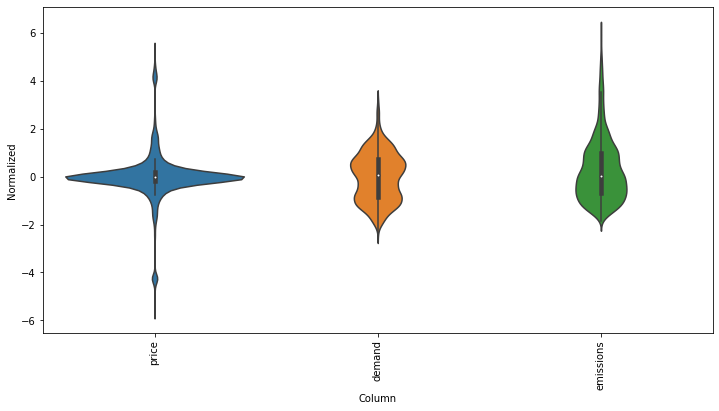

In [21]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Creation of windows

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=test_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['price'])
print(w1)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['price'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['price']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['price']


In [25]:
example_window = tf.stack([np.array(test_df[:w2.total_window_size]),
                           np.array(test_df[100:100+w2.total_window_size]),
                           np.array(test_df[200:200+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [26]:
w2.example = example_inputs, example_labels

In [27]:
def plot(self, model=None, plot_col='price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [28]:
# De momento, usaremos únicamente la target variable (Household dataset)
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.test_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [30]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
# Iteramos sobre un conjunto de dataset para producir lotes concretos:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

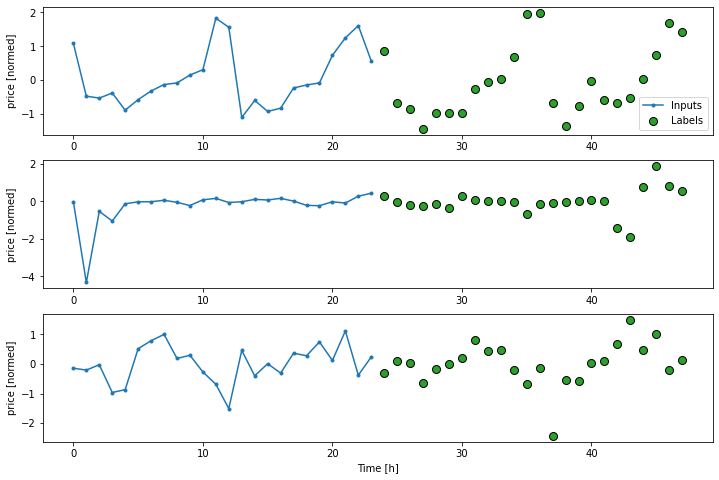

In [32]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

# RNN

## Convert the model into a function

In [33]:
MAX_EPOCHS = 20
patience = 4
num_features=df.shape[1] # TODO: Revisar esta línea
window = multi_window

In [34]:
multi_val_performance = {}
multi_performance = {}

In [35]:
def train_test_model(hparams):
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
        tf.keras.layers.LSTM(hparams[LSTM_UNITS], return_sequences=False),
        # Shape [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Dropout(.1),
        # Shape [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    multi_lstm_model.compile(loss=hparams[LOSS_FUNCTION],
                 optimizer=hparams[OPTIMIZER],
                 metrics=[tf.metrics.RootMeanSquaredError()])
    
    history = multi_lstm_model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, 
                        callbacks=[early_stopping]
                       )
    
    print(multi_lstm_model.evaluate(multi_window.test, verbose=0))
    loss, rmse = multi_lstm_model.evaluate(multi_window.test, verbose=0)
    
    return rmse

For each execution, generate a log containing the hyperparameter configuration and the metrics (rmse)

In [36]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)

In [37]:
session_num = 0

for lstm_unit in LSTM_UNITS.domain.values:
    for optimizer in OPTIMIZER.domain.values:
        for loss_function in LOSS_FUNCTION.domain.values:
            hparams = {
                LSTM_UNITS: lstm_unit,
                OPTIMIZER: optimizer,
                LOSS_FUNCTION: loss_function
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/RNN/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'LSTM_units': 16, 'Optimizer': 'adam', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 6ms/step - loss: 0.8388 - root_mean_squared_error: 0.9159 - val_loss: 1.4808 - val_root_mean_squared_error: 1.2169
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.7186 - root_mean_squared_error: 0.8477 - val_loss: 1.2063 - val_root_mean_squared_error: 1.0983
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6297 - root_mean_squared_error: 0.7935 - val_loss: 1.0715 - val_root_mean_squared_error: 1.0351
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5780 - root_mean_squared_error: 0.7603 - val_loss: 0.9811 - val_root_mean_squared_error: 0.9905
Epoch 5/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5383 - root_mean_squared_error: 0.7337 - val_loss: 0.9088 - val_root_mean_squared_error: 0.9533
Epoch 6/20
218/218 [=================

218/218 [==============================] - 1s 5ms/step - loss: 0.7844 - root_mean_squared_error: 0.8857 - val_loss: 1.4269 - val_root_mean_squared_error: 1.1945
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.7516 - root_mean_squared_error: 0.8670 - val_loss: 1.3078 - val_root_mean_squared_error: 1.1436
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.7193 - root_mean_squared_error: 0.8481 - val_loss: 1.2118 - val_root_mean_squared_error: 1.1008
Epoch 5/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6785 - root_mean_squared_error: 0.8237 - val_loss: 1.1211 - val_root_mean_squared_error: 1.0588
Epoch 6/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6383 - root_mean_squared_error: 0.7989 - val_loss: 1.0513 - val_root_mean_squared_error: 1.0253
Epoch 7/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6088 - root_mean_squared_error: 0.7803 - val_loss: 1.0019 - val_root_mean_s

218/218 [==============================] - 3s 6ms/step - loss: 0.8303 - root_mean_squared_error: 0.9112 - val_loss: 1.3337 - val_root_mean_squared_error: 1.1549
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6987 - root_mean_squared_error: 0.8359 - val_loss: 1.1248 - val_root_mean_squared_error: 1.0606
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6225 - root_mean_squared_error: 0.7890 - val_loss: 1.0353 - val_root_mean_squared_error: 1.0175
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5823 - root_mean_squared_error: 0.7631 - val_loss: 0.9767 - val_root_mean_squared_error: 0.9883
Epoch 5/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5470 - root_mean_squared_error: 0.7396 - val_loss: 0.9244 - val_root_mean_squared_error: 0.9615
Epoch 6/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5192 - root_mean_squared_error: 0.7206 - val_loss: 0.8987 - val_root_mean_s

[0.31249192357063293, 0.8801763653755188]
--- Starting trial: run-9
{'LSTM_units': 16, 'Optimizer': 'sgd', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 6ms/step - loss: 0.9971 - root_mean_squared_error: 0.9986 - val_loss: 2.3029 - val_root_mean_squared_error: 1.5175
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9896 - root_mean_squared_error: 0.9948 - val_loss: 2.2753 - val_root_mean_squared_error: 1.5084
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9813 - root_mean_squared_error: 0.9906 - val_loss: 2.2453 - val_root_mean_squared_error: 1.4984
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9719 - root_mean_squared_error: 0.9859 - val_loss: 2.2121 - val_root_mean_squared_error: 1.4873
Epoch 5/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9609 - root_mean_squared_error: 0.9802 - val_loss: 2.1748 - val_root_mean_squared_error: 1.4

Epoch 19/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3452 - root_mean_squared_error: 0.9602 - val_loss: 0.6641 - val_root_mean_squared_error: 1.4389
Epoch 20/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3427 - root_mean_squared_error: 0.9569 - val_loss: 0.6598 - val_root_mean_squared_error: 1.4320
[0.659839928150177, 1.432000994682312]
--- Starting trial: run-12
{'LSTM_units': 32, 'Optimizer': 'adam', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 7ms/step - loss: 0.7925 - root_mean_squared_error: 0.8902 - val_loss: 1.1672 - val_root_mean_squared_error: 1.0804
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6139 - root_mean_squared_error: 0.7835 - val_loss: 0.9360 - val_root_mean_squared_error: 0.9675
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5274 - root_mean_squared_error: 0.7262 - val_loss: 0.8355 - val_root_mean_squared_error: 0.

--- Starting trial: run-15
{'LSTM_units': 32, 'Optimizer': 'adamax', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 7ms/step - loss: 0.8485 - root_mean_squared_error: 0.9211 - val_loss: 1.4524 - val_root_mean_squared_error: 1.2052
Epoch 2/20
218/218 [==============================] - 1s 6ms/step - loss: 0.7420 - root_mean_squared_error: 0.8614 - val_loss: 1.2292 - val_root_mean_squared_error: 1.1087
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6801 - root_mean_squared_error: 0.8247 - val_loss: 1.0782 - val_root_mean_squared_error: 1.0384
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6197 - root_mean_squared_error: 0.7872 - val_loss: 0.9744 - val_root_mean_squared_error: 0.9871
Epoch 5/20
218/218 [==============================] - 1s 6ms/step - loss: 0.5847 - root_mean_squared_error: 0.7646 - val_loss: 0.9224 - val_root_mean_squared_error: 0.9604
Epoch 6/20
218/218 [==============

218/218 [==============================] - 1s 5ms/step - loss: 0.1589 - root_mean_squared_error: 0.6810 - val_loss: 0.3082 - val_root_mean_squared_error: 0.8707
[0.3082057237625122, 0.870714545249939]
--- Starting trial: run-18
{'LSTM_units': 32, 'Optimizer': 'rmsprop', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 6ms/step - loss: 0.7931 - root_mean_squared_error: 0.8906 - val_loss: 1.1119 - val_root_mean_squared_error: 1.0545
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.6283 - root_mean_squared_error: 0.7926 - val_loss: 0.9384 - val_root_mean_squared_error: 0.9687
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.5362 - root_mean_squared_error: 0.7322 - val_loss: 0.8576 - val_root_mean_squared_error: 0.9260
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.4956 - root_mean_squared_error: 0.7040 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9081
Epoc

218/218 [==============================] - 1s 6ms/step - loss: 0.1456 - root_mean_squared_error: 0.6456 - val_loss: 0.2936 - val_root_mean_squared_error: 0.8422
[0.29358795285224915, 0.8422454595565796]
--- Starting trial: run-21
{'LSTM_units': 32, 'Optimizer': 'sgd', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 2s 7ms/step - loss: 0.9949 - root_mean_squared_error: 0.9974 - val_loss: 2.2858 - val_root_mean_squared_error: 1.5119
Epoch 2/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9826 - root_mean_squared_error: 0.9913 - val_loss: 2.2394 - val_root_mean_squared_error: 1.4965
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9686 - root_mean_squared_error: 0.9842 - val_loss: 2.1867 - val_root_mean_squared_error: 1.4787
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.9513 - root_mean_squared_error: 0.9754 - val_loss: 2.1258 - val_root_mean_squared_error: 1.4580
Epoch 

218/218 [==============================] - 1s 5ms/step - loss: 0.3306 - root_mean_squared_error: 0.9421 - val_loss: 0.6397 - val_root_mean_squared_error: 1.3978
Epoch 20/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3272 - root_mean_squared_error: 0.9377 - val_loss: 0.6335 - val_root_mean_squared_error: 1.3876
[0.6335402131080627, 1.3875929117202759]
--- Starting trial: run-24
{'LSTM_units': 64, 'Optimizer': 'adam', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 3s 8ms/step - loss: 0.7302 - root_mean_squared_error: 0.8545 - val_loss: 0.9435 - val_root_mean_squared_error: 0.9713
Epoch 2/20
218/218 [==============================] - 1s 6ms/step - loss: 0.5235 - root_mean_squared_error: 0.7235 - val_loss: 0.7796 - val_root_mean_squared_error: 0.8829
Epoch 3/20
218/218 [==============================] - 1s 6ms/step - loss: 0.4559 - root_mean_squared_error: 0.6752 - val_loss: 0.8064 - val_root_mean_squared_error: 0.8980
Epoch

218/218 [==============================] - 2s 7ms/step - loss: 0.4093 - root_mean_squared_error: 0.6397 - val_loss: 0.7193 - val_root_mean_squared_error: 0.8481
Epoch 13/20
218/218 [==============================] - 2s 7ms/step - loss: 0.4021 - root_mean_squared_error: 0.6341 - val_loss: 0.7103 - val_root_mean_squared_error: 0.8428
Epoch 14/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3963 - root_mean_squared_error: 0.6295 - val_loss: 0.7113 - val_root_mean_squared_error: 0.8434
Epoch 15/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3905 - root_mean_squared_error: 0.6249 - val_loss: 0.7171 - val_root_mean_squared_error: 0.8468
Epoch 16/20
218/218 [==============================] - 1s 7ms/step - loss: 0.3842 - root_mean_squared_error: 0.6199 - val_loss: 0.7054 - val_root_mean_squared_error: 0.8399
Epoch 17/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3790 - root_mean_squared_error: 0.6156 - val_loss: 0.7013 - val_root_m

218/218 [==============================] - 2s 7ms/step - loss: 0.3508 - root_mean_squared_error: 0.5922 - val_loss: 0.6927 - val_root_mean_squared_error: 0.8323
Epoch 11/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3412 - root_mean_squared_error: 0.5841 - val_loss: 0.7179 - val_root_mean_squared_error: 0.8473
Epoch 12/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3332 - root_mean_squared_error: 0.5772 - val_loss: 0.7436 - val_root_mean_squared_error: 0.8623
Epoch 13/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3260 - root_mean_squared_error: 0.5710 - val_loss: 0.7139 - val_root_mean_squared_error: 0.8449
Epoch 14/20
218/218 [==============================] - 2s 7ms/step - loss: 0.3170 - root_mean_squared_error: 0.5630 - val_loss: 0.7296 - val_root_mean_squared_error: 0.8541
[0.7295500636100769, 0.854137122631073]
--- Starting trial: run-31
{'LSTM_units': 64, 'Optimizer': 'rmsprop', 'Loss_function': 'MeanSquaredLogarith

218/218 [==============================] - 2s 7ms/step - loss: 0.7933 - root_mean_squared_error: 0.8907 - val_loss: 1.4650 - val_root_mean_squared_error: 1.2104
Epoch 17/20
218/218 [==============================] - 2s 7ms/step - loss: 0.7885 - root_mean_squared_error: 0.8880 - val_loss: 1.4482 - val_root_mean_squared_error: 1.2034
Epoch 18/20
218/218 [==============================] - 2s 7ms/step - loss: 0.7843 - root_mean_squared_error: 0.8856 - val_loss: 1.4326 - val_root_mean_squared_error: 1.1969
Epoch 19/20
218/218 [==============================] - 2s 7ms/step - loss: 0.7793 - root_mean_squared_error: 0.8828 - val_loss: 1.4177 - val_root_mean_squared_error: 1.1907
Epoch 20/20
218/218 [==============================] - 2s 7ms/step - loss: 0.7759 - root_mean_squared_error: 0.8809 - val_loss: 1.4043 - val_root_mean_squared_error: 1.1850
[1.4042763710021973, 1.1850217580795288]
--- Starting trial: run-34
{'LSTM_units': 64, 'Optimizer': 'sgd', 'Loss_function': 'MeanSquaredLogarithmic

[0.727683424949646, 0.8530437350273132]
--- Starting trial: run-37
{'LSTM_units': 128, 'Optimizer': 'adam', 'Loss_function': 'MeanSquaredLogarithmicError'}
Epoch 1/20
218/218 [==============================] - 4s 14ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
Epoch 2/20
218/218 [==============================] - 3s 14ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
Epoch 3/20
218/218 [==============================] - 3s 15ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
Epoch 4/20
218/218 [==============================] - 3s 15ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
Epoch 5/20
218/218 [==============================] - 3s 15ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_s

Epoch 8/20
218/218 [==============================] - 4s 16ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
Epoch 9/20
218/218 [==============================] - 4s 16ms/step - loss: 0.1735 - root_mean_squared_error: 1.0004 - val_loss: 0.4489 - val_root_mean_squared_error: 1.5263
[0.44890522956848145, 1.5262736082077026]
--- Starting trial: run-41
{'LSTM_units': 128, 'Optimizer': 'adamax', 'Loss_function': 'huber'}
Epoch 1/20
218/218 [==============================] - 4s 16ms/step - loss: 0.2787 - root_mean_squared_error: 0.8700 - val_loss: 0.4065 - val_root_mean_squared_error: 1.0125
Epoch 2/20
218/218 [==============================] - 3s 15ms/step - loss: 0.2124 - root_mean_squared_error: 0.7746 - val_loss: 0.3497 - val_root_mean_squared_error: 0.9288
Epoch 3/20
218/218 [==============================] - 3s 16ms/step - loss: 0.1837 - root_mean_squared_error: 0.7258 - val_loss: 0.3193 - val_root_mean_squared_error: 0.88

Epoch 7/20
218/218 [==============================] - 4s 17ms/step - loss: 0.1400 - root_mean_squared_error: 0.6262 - val_loss: 0.2708 - val_root_mean_squared_error: 0.8132
Epoch 8/20
218/218 [==============================] - 4s 17ms/step - loss: 0.1353 - root_mean_squared_error: 0.6133 - val_loss: 0.2697 - val_root_mean_squared_error: 0.8088
Epoch 9/20
218/218 [==============================] - 4s 17ms/step - loss: 0.1315 - root_mean_squared_error: 0.6020 - val_loss: 0.2740 - val_root_mean_squared_error: 0.8136
[0.2740132212638855, 0.8136316537857056]
--- Starting trial: run-45
{'LSTM_units': 128, 'Optimizer': 'sgd', 'Loss_function': 'MeanSquaredError'}
Epoch 1/20
218/218 [==============================] - 5s 17ms/step - loss: 0.9945 - root_mean_squared_error: 0.9973 - val_loss: 2.2724 - val_root_mean_squared_error: 1.5075
Epoch 2/20
218/218 [==============================] - 3s 16ms/step - loss: 0.9807 - root_mean_squared_error: 0.9903 - val_loss: 2.2032 - val_root_mean_squared_erro

Epoch 15/20
218/218 [==============================] - 3s 13ms/step - loss: 0.3147 - root_mean_squared_error: 0.9206 - val_loss: 0.5848 - val_root_mean_squared_error: 1.3008
Epoch 16/20
218/218 [==============================] - 3s 14ms/step - loss: 0.3113 - root_mean_squared_error: 0.9162 - val_loss: 0.5760 - val_root_mean_squared_error: 1.2853
Epoch 17/20
218/218 [==============================] - 3s 14ms/step - loss: 0.3089 - root_mean_squared_error: 0.9133 - val_loss: 0.5691 - val_root_mean_squared_error: 1.2728
Epoch 18/20
218/218 [==============================] - 3s 14ms/step - loss: 0.3070 - root_mean_squared_error: 0.9107 - val_loss: 0.5634 - val_root_mean_squared_error: 1.2626
Epoch 19/20
218/218 [==============================] - 3s 14ms/step - loss: 0.3056 - root_mean_squared_error: 0.9089 - val_loss: 0.5587 - val_root_mean_squared_error: 1.2541
Epoch 20/20
218/218 [==============================] - 3s 14ms/step - loss: 0.3043 - root_mean_squared_error: 0.9072 - val_loss: 0

In [38]:
%tensorboard --logdir logs/RNN --port 6008

In [39]:
%tensorboard --logdir logs/RNN

---------------------------------------------

In [40]:
# num_features=df.shape[1] # TODO: Revisar esta línea

In [41]:
# MAX_EPOCHS = 20

# def compile_and_fit(model, window, patience=4):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
#     model.compile(loss=tf.losses.MeanSquaredError(),
#                  optimizer=tf.optimizers.Adam(),
#                  metrics=[tf.metrics.RootMeanSquaredError()])
    
#     history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, 
#                         callbacks=[early_stopping]
#                        )
    
#     return history

In [42]:
# multi_val_performance = {}
# multi_performance = {}

In [43]:
# multi_lstm_model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units]
#     # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
#     tf.keras.layers.LSTM(32, return_sequences=False),
#     # Shape [batch, out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
#     tf.keras.layers.Dropout(.1),
#     # Shape [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

# history = compile_and_fit(multi_lstm_model, multi_window)

# # IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_lstm_model)

### 